In [1]:
import os
import time
import math

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import gym

In [3]:
env_name = 'Breakout-v0'
env = gym.make(env_name)

In [4]:
env.action_space.sample()

3

In [5]:
env.action_space.n

4

In [6]:
env.observation_space.shape

(210, 160, 3)

In [7]:
state = env.reset()
state.shape

(210, 160, 3)

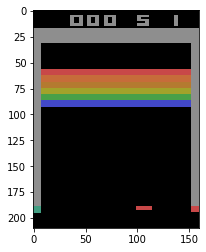

In [8]:
plt.imshow(state)

**Convert RGB to GRAY**

In [9]:
gray = np.mean(state, axis=2)
gray.shape

(210, 160)

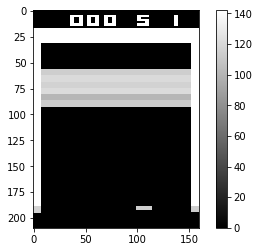

In [10]:
plt.imshow(gray, cmap='gray')
plt.colorbar()

**Resize (down-sample) image**

In [11]:
down_sample = gray[::2, ::2]
down_sample.shape

(105, 80)

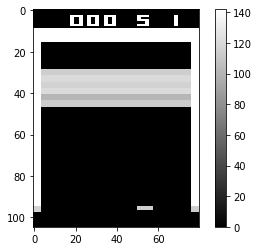

In [12]:
plt.imshow(down_sample, cmap='gray')
plt.colorbar()

**Convert to 0 or 255** 

In [40]:
abs_img = np.where(down_sample == 0, 0, 255).astype(np.uint8)
abs_img.shape

(105, 80)

In [41]:
abs_img.dtype

dtype('uint8')

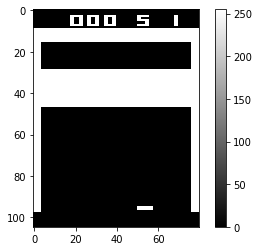

In [43]:
plt.imshow(abs_img, cmap='gray')
plt.colorbar()

**Wrap all together**

In [77]:
def process_state(img):
    _img = np.mean(img, axis=2, dtype=np.uint8)
    _img = _img[::2, ::2]
    _img = np.where(_img==0, 0, 255).astype(np.uint8)
    return _img

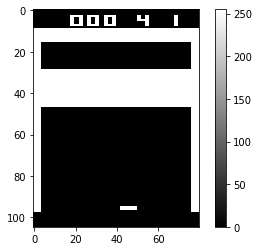

In [45]:
plt.imshow(process_state(state), cmap='gray')
plt.colorbar()

In [15]:
_state = process_state(state)
_state.shape

(105, 80)

In [16]:
state.dtype

dtype('uint8')

In [17]:
_state.dtype

dtype('uint8')

In [46]:
state_memory = []

In [47]:
for _ in range(64):
    action = env.action_space.sample()
    observation = env.step(action)
    state, reward, done, info = observation
    _state = process_state(state)
    state_memory.append(_state)

In [48]:
len(state_memory)

64

In [49]:
idx = 0

8


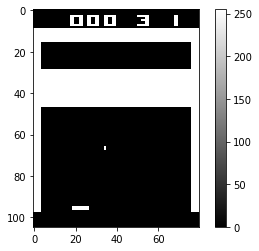

In [57]:
idx %= len(state_memory)
idx += 1
print(idx)
plt.imshow(state_memory[idx], cmap='gray')
plt.colorbar()

**Grab sequence of frames**

In [58]:
seq_states = np.array(state_memory[20:30])
seq_states.shape

(10, 105, 80)

In [59]:
seq_states.dtype

dtype('uint8')

**Merge them together**

In [60]:
max_seq_states = np.max(seq_states, axis=0)
max_seq_states.shape

(105, 80)

In [61]:
max_seq_states.dtype

dtype('uint8')

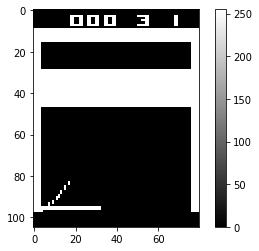

In [62]:
plt.imshow(max_seq_states, cmap='gray')
plt.colorbar()

**Fade frame**

In [63]:
process_seq_state = []

for idx, s in enumerate(seq_states):
    # fade past images
    alpha = idx / len(seq_states)
    s = s * alpha
    process_seq_state.append(s)

process_seq_state = np.array(process_seq_state, dtype=np.uint8)
process_seq_state = np.max(process_seq_state, axis=0)

In [64]:
process_seq_state.shape

(105, 80)

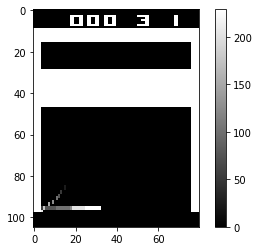

In [65]:
plt.imshow(process_seq_state, cmap='gray')
plt.colorbar()

In [66]:
def ray_trace(seq_images):
    process_seq = []

    for idx, s in enumerate(seq_images):
        s = s * ((idx+1) / len(seq_images))
        process_seq.append(s)
    process_seq = np.array(process_seq, dtype=np.uint8)
    ray_trace_image = np.max(process_seq, axis=0)
    return ray_trace_image

In [73]:
idx = 60
# grab `x` sequential frames
x = 8
ray_trace_image = ray_trace(state_memory[idx-8:idx])
ray_trace_image.shape

(105, 80)

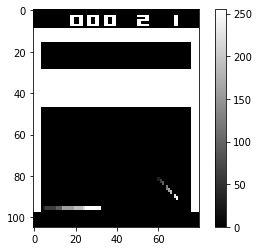

In [74]:
plt.imshow(ray_trace_image, cmap='gray')
plt.colorbar()

**Tranditional Q-Learning update equation**

$Q_{s,a} \leftarrow (1 - \alpha) Q_{s,a} + \alpha (reward + \gamma \max(Q_{s'})$

In [34]:
import tensorflow as tf
tf.__version__

'2.0.0-alpha0'

In [35]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [81]:
model_filename = f'{env_name}.h5'
model_filename

'Breakout-v0.h5'

In [82]:
model = keras.models.load_model(model_filename)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 19, 32)        2080      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 8, 64)         32832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 6, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 3456)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 13828     
Total params: 85,668
Trainable params: 85,668
Non-trainable params: 0
_________________________________________________________________


Test unpack `input_shape`

In [36]:
(*(105, 80, 1), )

(105, 80, 1)

In [75]:
from dqn_utils import *

**Populate DQN memory**

In [76]:
dqn_memory = DQNMemory()

In [78]:
done = False
state = env.reset()
state = process_state(state)
dqn_memory.states.append(state)

while not done:
    action = env.action_space.sample()
    observation = env.step(action)

    new_state, reward, done, info = observation

    new_state = process_state(new_state)
    # add new observation to `dqn_memory`
    dqn_memory.add(new_state, action, reward)

In [80]:
len(dqn_memory.states)

257